# Credit Card Fruad Detection
1. Data Description
    - transactions made by credit cards in 09.2013 (2 days) by European cardholders 
    - 492 frauds out of 284,807 transactions 
2. UNBALANCED data
    - positive class (frauds) = 0.172% 
        - use AUCPR metric
    - only numerical input variables which are the result of PCA TRANSFORMATION 
3. features:
    - `V1`, `V2`, ..., `V28`: prinipal components obtained with PCA
    - `Time`, `Amount`: the only features which have not been transformed with PCA 
        - `Time`: seconds elapsed between each transaction and the first transaction 
        - `Amount`: transaction amount 
            - can be used for example-dependatn cost-sensitive learning 
    - `Class`: response variable 
        - 1: fruad case
        - 0: otherwise
    - due to confidentiality issues, the original features and more background information about the data isn't provided



## Reference
- [Dataset-Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
- [Simulator for transaction data](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html)

# 0.Libraries

In [ ]:
# Module import
import tensorflow as tf

import numpy as np # linear algebra
import pandas as pd # data processing ,CSV file 
import seaborn as sns 

import matplotlib.pyplot as plt
import matplotlib.patches as mpathces 

from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA, TruncatedSVD 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

In [ ]:
# google mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.Data Load

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/creditcard.csv',
                 delimiter = ',',
                 dtype=np.float32)
print(df.shape)

(284807, 31)


In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.619995,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660004,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.989998,0.0


In [ ]:
df.keys()
# OR df.columns 

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

# 2.Preprocessing

## 2.1 Missing Value Check

In [ ]:
df.info()
# missing value counts  
## df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float32
 1   V1      284807 non-null  float32
 2   V2      284807 non-null  float32
 3   V3      284807 non-null  float32
 4   V4      284807 non-null  float32
 5   V5      284807 non-null  float32
 6   V6      284807 non-null  float32
 7   V7      284807 non-null  float32
 8   V8      284807 non-null  float32
 9   V9      284807 non-null  float32
 10  V10     284807 non-null  float32
 11  V11     284807 non-null  float32
 12  V12     284807 non-null  float32
 13  V13     284807 non-null  float32
 14  V14     284807 non-null  float32
 15  V15     284807 non-null  float32
 16  V16     284807 non-null  float32
 17  V17     284807 non-null  float32
 18  V18     284807 non-null  float32
 19  V19     284807 non-null  float32
 20  V20     284807 non-null  float32
 21  V21     28

In [ ]:
df.isnull().sum() / df.shape[0]
# How to deal with missing value:  
## methods: 1) drop(delete), 2)fill-out with averages on missing value spaces  

Time      0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Amount    0.0
Class     0.0
dtype: float64

# 3.Correlation Visulation

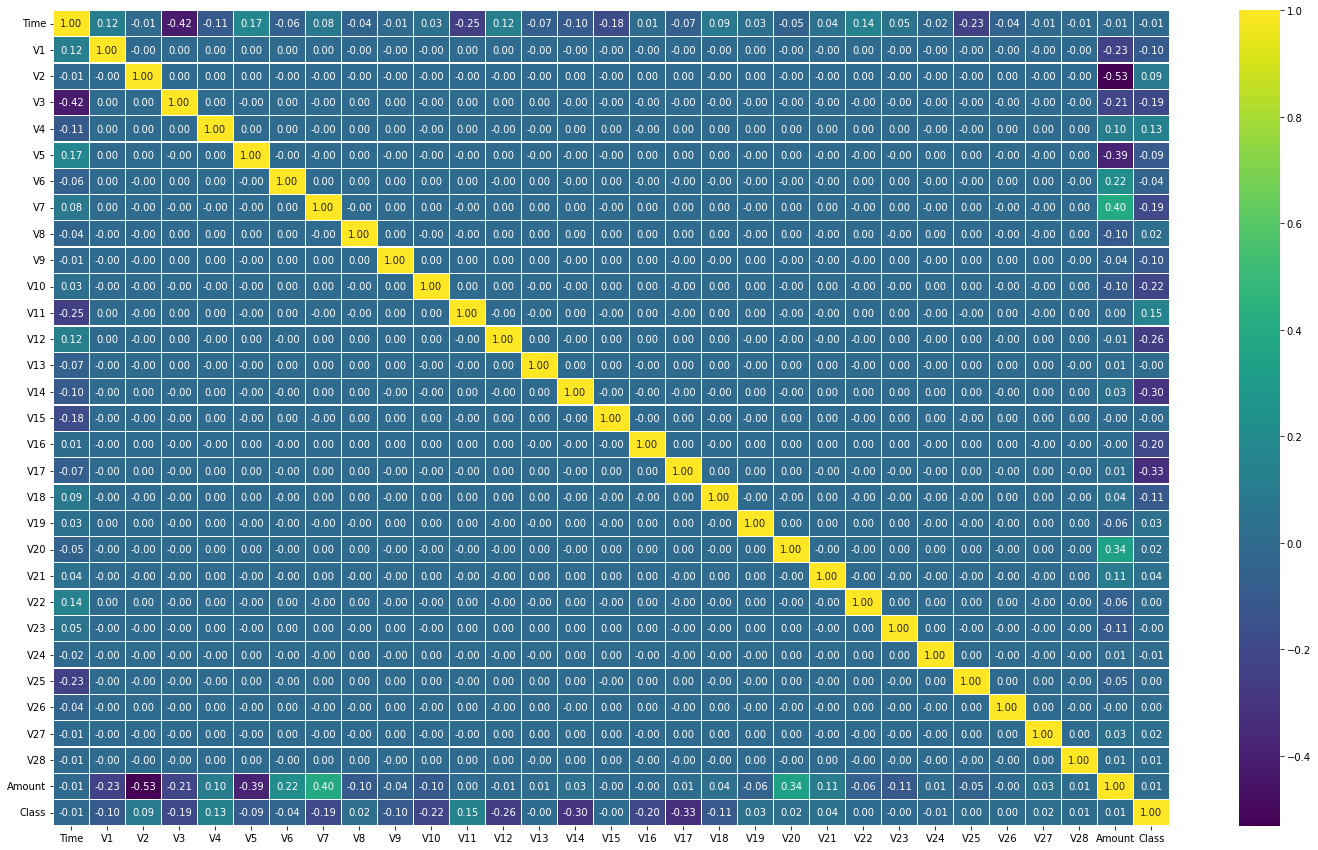

In [ ]:
# heatmap for visualizing correlations between features 
import seaborn
f, ax = plt.subplots(figsize = (25,15))
seaborn.heatmap(df.corr(), annot=True, linewidth=0.3, fmt='0.2f',
                ax=ax,
                cmap='viridis')
plt.show()

# Credit Card Data: results from PCA (except `Time`, `Amount`) --> low correlation 
# If features have HIGH CORRELATION: 
## methods: 1) DROP features which have high correlation, 2) PCA transform, 3) detect Multicolinearity with VIF 

# 4.EDA
- Exploratory Data Analysis

In [ ]:
print(df['Class'].value_counts())
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes.head()
print()

print(df['Class'].value_counts(normalize=True)) # percentage form <-- normalize=True

# 1.0: fruad transaction
# 0.0: otherwise 

0.0    284315
1.0       492
Name: Class, dtype: int64

0.0    0.998273
1.0    0.001727
Name: Class, dtype: float64


## 4.1 Unbalance
- positive class (frauds) = 0.172% [serious IMBALANCE]
    - Accuracy isn't recommended 
    - metrics: precision, recall, f1-score

Text(0.5, 1.0, 'Transcation Class Distribution')

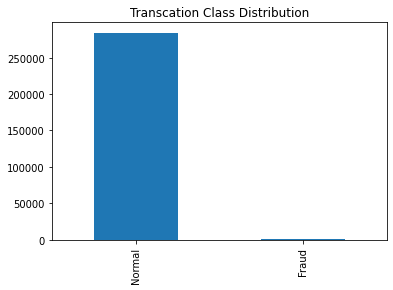

In [ ]:
labels = ['Normal', 'Fraud']
count_classes.plot(kind='bar')

plt.xticks(range(2), labels)
plt.title('Transcation Class Distribution')

## 4.2 Time, Amount columns

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 172792.0)

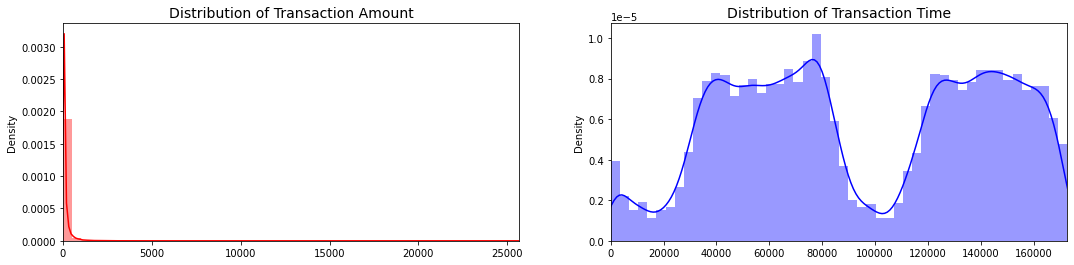

In [ ]:
# EDA: Time, Amount features Distribution 
fig, ax = plt.subplots(1, 2, figsize = (18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

# Distribution of Transaciton Amount 
## not Gaussian Distribution shape 
sns.distplot(amount_val, ax = ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

# Distribution of Transaction Time 
## not Gaussian Distribution shape 
sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

In [ ]:
# Time: features elapsed between first and second transaction [NOT HELPFUL FEATURE]
## ==> delete columns

df.drop(columns = 'Time', inplace = True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.619995,0.0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0.0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660004,0.0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0.0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.989998,0.0


In [ ]:
# data split
x_data = df.iloc[:, 0:-1].values # x_data: features
y_data = df.iloc[:, [-1]].values # y_data: label (`Class` column)

# for calcuation --> dtype to be same (both x_data, y_data to be np.float32)
x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)
print(x_data.shape, y_data.shape)

(284807, 29) (284807, 1)


## 4.3 Scaling 
- MinMaxScaler: values become between 0~1
    - `V1`, `V2`,.., `V28`: near zero
    - `Amount`: have different scales 
    - sensitive to outliers 
- StandardScaler: good to use when the distribution follows Gaussian Distribution
    - less sensitive to outliers 
    - BUT if many noise --> becomes sensitive 


In [ ]:
scaler = MinMaxScaler()
x_data = scaler.fit_transform(x_data)
print(x_data) 

[[9.3519241e-01 7.6649040e-01 8.8136494e-01 ... 4.1897613e-01
  3.1269664e-01 5.8237929e-03]
 [9.7854203e-01 7.7006662e-01 8.4029853e-01 ... 4.1634512e-01
  3.1342265e-01 1.0470528e-04]
 [9.3521708e-01 7.5311762e-01 8.6814088e-01 ... 4.1548926e-01
  3.1191131e-01 1.4738923e-02]
 ...
 [9.9090487e-01 7.6407969e-01 7.8110206e-01 ... 4.1659316e-01
  3.1258485e-01 2.6421540e-03]
 [9.5420909e-01 7.7285570e-01 8.4958714e-01 ... 4.1851953e-01
  3.1524515e-01 3.8923896e-04]
 [9.4923186e-01 7.6525640e-01 8.4960151e-01 ... 4.1646636e-01
  3.1340083e-01 8.4464857e-03]]


# 5.Logistic Regression
- BINARY CLASSIFICATION: logistic regression 
    - activation function: sigmoid 
    - cost funciton: Cross-entropy

In [ ]:
# Parameter Initialization
tf.random.set_seed(22)

W = tf.Variable(tf.random.normal([29, 1], mean=0.0))
b = tf.Variable(tf.random.normal([1], mean=0.0))

In [ ]:
# Hypothesis Define
## define relationship between FEATURE and LABEL 
### binary classification --> Logistic Regression 
def hypothesis(x):
    z = tf.matmul(x,W) + b
    sigmoid = 1/(1+tf.exp(-z))
    return sigmoid

In [ ]:
# Cost Function Define (Loss Function)
## Cross Entropy: logistic regression's loss function  
def cost_function(H,Y):
    cost = tf.reduce_mean(Y * tf.math.log(H) + (1-Y)*tf.math.log(1-H))
    return cost 

In [ ]:
# Metric Define (OR use accuracy metrics from importing metrics library)
def accuracy(hypo, label):
    predicted = tf.cast(hypo>0.5, dtype=tf.float32)  # 1 OR 0 according to fraud OR otherwise

    # if predict, label(true) are same --> add 1, different --> add 0 
    ## reduce_mean: reduces input_tensor along the dimensions given in axis 
    ###             by computing the mean of elements across the dimensions in axis
    accuracyd = tf.reduce_mean(tf.cast(tf.equal(predicted, label), 
                                       dtype=tf.float32)) 
    return accuracyd

In [ ]:
# Hyper-Parameter Setting 
# Logistic Regression (ML model) ==> only learning rate & Optimizer setting is needed   

# hyper-parameters: learning rate, optimizer, 
##                  epochs, actvation function, number of layer, number of neuron etc. 
learning_rate = 0.0001
optimizer = tf.optimizers.SGD(learning_rate)

In [ ]:
# Training 
for step in range(2022):
    with tf.GradientTape() as g:
        pred = hypothesis(x_data) 
        cost = cost_function(pred, y_data)

        gradients = g.gradient(cost, [W, b])

    optimizer.apply_gradients(zip(gradients, [W,b]))

    if step % 200 == 0:
        print(f'step: {step}, loss: {cost.numpy()}')

    w_hat = W.numpy()
    b_hat = b.numpy()

step: 0, loss: -0.015813227742910385
step: 200, loss: -0.015820719301700592
step: 400, loss: -0.015828218311071396
step: 600, loss: -0.01583576574921608
step: 800, loss: -0.015843434259295464
step: 1000, loss: -0.01585111953318119
step: 1200, loss: -0.01585881970822811
step: 1400, loss: -0.015866532921791077
step: 1600, loss: -0.015874288976192474
step: 1800, loss: -0.015882061794400215
step: 2000, loss: -0.01588987372815609


## 5.1 Logistic Regression RESULT 
- metrics
    - Precision: (TP) / (predicted True) 
    - Recall: (TP) / (real True) 
    - F1 score: harmonic mean of Precision and Recall (if bigger than 0.6~0.7 --> GOOD)

- RESULT:
    - performance is evaluated from precision, recall, f1_score (which are used instead of Accuracy) 
    - BUT result is 0 and 1 
        - (=) classified poorly
    - ==> Thus, try DIFFERENT MODEL 

In [ ]:
# Score: Accuracy
## becuase of imbalanace (frad transaction is only 0.172%) --> accuracy becomes 99.827%  

acc = accuracy(hypothesis(x_data), y_data).numpy()
print(f'Accuracy: {acc}')

Accuracy: 0.9982725381851196


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

predicted_x = tf.cast(hypothesis(x_data) > 0.5,  
                      dtype = tf.float32)

print('Accuracy = ', accuracy_score(predicted_x, y_data))

# precision, recall, f1-score
print('Report = \n', classification_report(predicted_x, y_data))

# performance result is 1.00, 0.00 --> classified poorly

Accuracy =  0.9982725143693799


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Report = 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    284807
         1.0       0.00      0.00      0.00         0

    accuracy                           1.00    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       1.00      1.00      1.00    284807



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 6.Other ML methods
- didn't use Early Stopping --> use very dataset as training data (no validation set) 
1. Ensemble Model
    - 1) Bagging:
        - training a bunch of individual models in a PARALLEL way. 
        - each model is trained by a random subset of the data
        - ex) ***Random forest***

    - 2) Boosting: 
        - training a bunch of individual models in a SEQUENTIAL way 
        - each individual model learns from mistakes made by the previous model
        - ex) ***XGBoost, LGBM***

2. ML
    - 100,000~999,999 data size --> ML is more effective
    - more base of Math & Stats than DL


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    test_size=0.2,
                                                    random_state=1)

## 6.1 Support Vector Machine
support vector classifier

In [ ]:
from sklearn.svm import SVC 

# Support Vector Classifier 
SVC_model = SVC(kernel='rbf')  
SVC_model.fit(x_train, y_train) 

SVC_predict = tf.cast(SVC_model.predict(x_test) > 0.5,  # tf.cast: casts a tensor to new type 
                      dtype = tf.float32)

print('Test Report = \n', classification_report(SVC_predict, y_test))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Report = 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56880
         1.0       0.75      0.79      0.77        82

    accuracy                           1.00     56962
   macro avg       0.87      0.90      0.88     56962
weighted avg       1.00      1.00      1.00     56962



## 6.2 Random Forest
ensemble model using ***1) bagging*** as the ensemble model and ***2) decision trees*** as the individual model 
- Process 
1. select n random subsets from the traininig set
2. train each decision tree
3. each individual tree predicts the records/candidates in the test set, independently 
4. Make the final prediction
    - for each candiidate in the test set, Random Forest uses the class (e.g. cat OR dog) with the ***majority vote*** as this candidate's final prediction

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RandomForest_model = RandomForestClassifier(n_estimators = 10,
                                            oob_score=False)
RandomForest_model.fit(x_train, y_train)
RF_predict = tf.cast(RandomForest_model.predict(x_test) > 0.5, 
                     dtype = tf.float32)

print("Test Report = \n", classification_report(RF_predict, y_test))

<ipython-input-26-2e207870497c>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RandomForest_model.fit(x_train, y_train)


Test Report = 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56893
         1.0       0.75      0.94      0.83        69

    accuracy                           1.00     56962
   macro avg       0.87      0.97      0.92     56962
weighted avg       1.00      1.00      1.00     56962



## 6.3 XGboost (XGB)
1. GBDT(Gradient Boosting Decision Tree)
    -  ensemble algorihthm
    - fits boosted decision trees by minimizing an error gradient 
        - new models are created that predict the residuals(errors) of prior models
        - added together to make the final prediction 
        - use ***gradient descent algorithm*** to minimize the loss when adding new models 
    - effective implementations: XGBoost, LightGBM, pGBRT

2. GBDT process
    - 1) train a decision tree
    - 2) apply the decision tree just trained to predict 
    - 3) calculate the residual of this decision tree, Save residual errors as the new Y 
    - 4) repeat step-1 
    - 5) make the final prediction 
        - (=) SUM of prediction of tree 1, tree 2, ..., tree n 
        - GB makes a new prediction by simply adding up the predictions of all trees. 

3. XGBoost
    - Extreme Gradient Boosting 
        - provides an efficient implementation of the gradient boosting algorithm 
    - benefit: 
        - ***computation efficiency***
        - better model performance





In [ ]:
# hyperparameter setting isn't needed. 
from xgboost import XGBClassifier

Xgboost_model = XGBClassifier()
Xgboost_model.fit(x_train, y_train, eval_metric='aucpr')

Xg_predict = tf.cast(Xgboost_model.predict(x_test) > 0.5, 
                     dtype = tf.float32)

print('Test Report = \n', classification_report(Xg_predict, y_test))

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Report = 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56890
         1.0       0.77      0.93      0.84        72

    accuracy                           1.00     56962
   macro avg       0.89      0.97      0.92     56962
weighted avg       1.00      1.00      1.00     56962



## 6.4 Light Gradient Boosting (LGBM)
1. Light GBM
    - gradient boosting framework that uses tree-based learning algorithms 
    - Benefit:
        - training speed --> LIGHT 
        - higher efficiency
            - take lower memory to run  
        - ***BETTER ACCURACY***
        - capable of handling large-scale data 
    - 성능 X. 속도 O.

In [ ]:
# hyperparameter - sensitive to setting
## ==> setting is recommended.
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model.fit(x_train, y_train, eval_metric = 'aucpr') 

LGBM_predict = tf.cast(LGBM_model.predict(x_test) > 0.5, 
                       dtype = tf.float32)
print('Test Report = \n', classification_report(LGBM_predict, y_test))

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Report = 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56788
         1.0       0.55      0.28      0.37       174

    accuracy                           1.00     56962
   macro avg       0.77      0.64      0.68     56962
weighted avg       1.00      1.00      1.00     56962



# 7.Neural Networks - ANN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from keras import optimizers, metrics, callbacks

## 7.1 Preprocessing - Data Split

In [ ]:
# Training:test = 8:2
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    test_size=0.2,
                                                    random_state=1)

# Training --> Training:Validation = 8:2
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=0.2,
                                                  random_state=1)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(182276, 29) (182276, 1)
(45569, 29) (45569, 1)
(56962, 29) (56962, 1)


## 7.2 Neural Network Design

In [ ]:
model = Sequential([

    # Input Layer: decide INPUT SIZE according to DIMENSION
    Dense(256, activation='relu', input_shape=(x_train.shape[-1],)),
    BatchNormalization(),  # BatchNormalization: for fast&stable train  
    Dropout(0.3),

    # Prevent OVERFITTING: 1) Drop-out is applied for every Hidden Layer, 2) BatchNormalization  
    ## through Hidden Layer, # of neuron becomes decreased ==> information becomes compressed 
    Dense(128, activation='relu'),  # hidden layer activation function --> ReLU GOOD 
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Hidden layer right before Output Layer: activation function = softmax 
    Dense(10, activation='softmax'),
    BatchNormalization(),
    Dropout(0.3),

    # Binary Classification ==> Output Layer activation function = sigmoid
    Dense(1, activation='sigmoid')
])

model.summary()  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7680      
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

## 7.3 Model Compile
- hyper-parameter
- Optimizer 
- loss function 

In [ ]:
model.compile(optimizer = optimizers.Adam(1e-4), # Optimizer: ADAM 
                                ## default learning rate: 1e-3 ==> Big ==> unstable training 
                                ### --> decrease learning rate to 1e-4    
              
              # Loss Function: Binary Classification --> binary_crossentropy 
              loss = 'binary_crossentropy',  

              # Evaluation metrics: recall, precision 
              metrics = [metrics.Recall(name='recall'), 
                         metrics.Precision(name='precision')])

# EarlyStopping 
## callback: during eopch, save the parameter that provided BEST PERFORMANCE 
callbacks = [callbacks.ModelCheckpoint('epoch.h5')]

## 7.4 Training 
- increase epoch, training accuracy becomes better (of course)
    - BUT, test accuracy: problem of OVERFITTING  
- Early Stopping 
    - if use early Stopping, increasing epoch infinitey CAN perform well 
        - BUT using Early Stopping = should split validation set ==> data set becomes SMALLER

In [ ]:
history = model.fit(x_train, y_train,
                    validation_data = (x_val, y_val),

                    # batch_size: 2^x number 
                    ## half of data size(190,000) = 90,000 is best 
                    batch_size = 65536,  # bigger, better. 
                    epochs = 1000,
                    callbacks = callbacks)  # prevent overfitting:  

score = model.evaluate(x_test, y_test)
print(score)

Epoch 1/1000
3/3 [==============================] - 3s 320ms/step - loss: 0.9379 - recall: 0.5518 - precision: 0.0020 - val_loss: 0.6391 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/1000
3/3 [==============================] - 0s 94ms/step - loss: 0.9316 - recall: 0.5396 - precision: 0.0020 - val_loss: 0.6383 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/1000
3/3 [==============================] - 0s 88ms/step - loss: 0.9289 - recall: 0.5335 - precision: 0.0020 - val_loss: 0.6377 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/1000
3/3 [==============================] - 0s 83ms/step - loss: 0.9227 - recall: 0.5335 - precision: 0.0020 - val_loss: 0.6370 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/1000
3/3 [==============================] - 0s 84ms/step - loss: 0.9173 - recall: 0.5976 - precision: 0.0022 - val_loss: 0.6363 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 6/1000
3/3 [==============================] - 0s

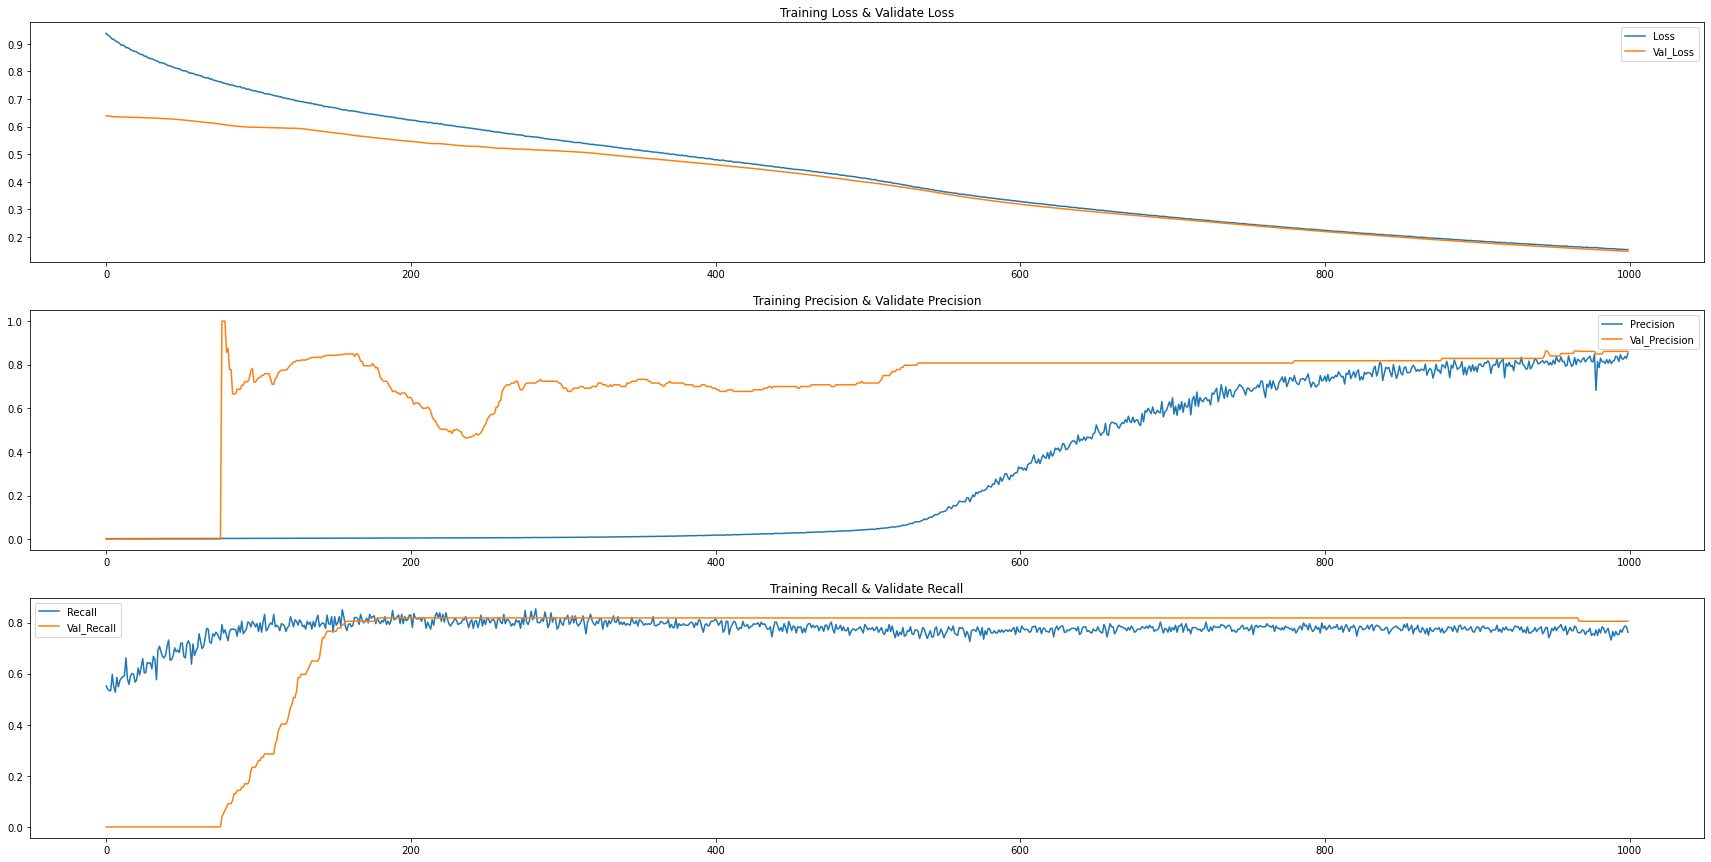

In [ ]:
plt.figure(figsize=(30,15))

plt.subplot(3,1,1)
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Val_Loss')
plt.title('Training Loss & Validate Loss')
plt.legend()

plt.subplot(3,1,2)
plt.plot(history.history['precision'], label = 'Precision')
plt.plot(history.history['val_precision'], label = 'Val_Precision')
plt.title('Training Precision & Validate Precision')
plt.legend()

plt.subplot(3,1,3)
plt.plot(history.history['recall'], label = 'Recall')
plt.plot(history.history['val_recall'], label = 'Val_Recall')
plt.title('Training Recall & Validate Recall')
plt.legend()


## 7.5 ANN Performance Evaluation

In [ ]:
ANN_predict = tf.cast(model.predict(x_test) > 0.5,
                      dtype=tf.float32)

print('Test Report = \n', classification_report(ANN_predict, y_test))

1781/1781 [==============================] - 3s 2ms/step
Test Report = 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56885
         1.0       0.74      0.83      0.78        77

    accuracy                           1.00     56962
   macro avg       0.87      0.92      0.89     56962
weighted avg       1.00      1.00      1.00     56962



# 8.Model Comparison

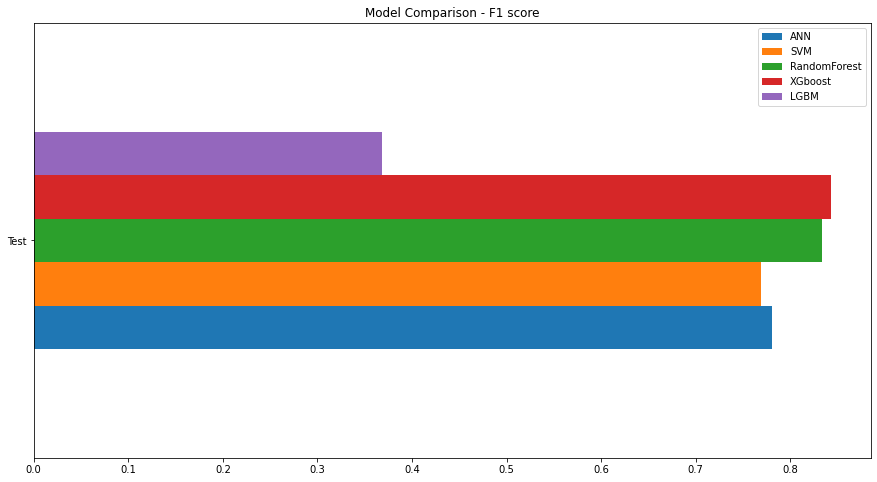

In [ ]:
F1_dict={}
F1_dict['ANN'] = {'Test': f1_score(ANN_predict, y_test)}
F1_dict['SVM'] = {'Test': f1_score(SVC_predict, y_test)}
F1_dict['RandomForest'] = {'Test': f1_score(RF_predict, y_test)}
F1_dict['XGboost'] = {'Test': f1_score(Xg_predict, y_test)}
F1_dict['LGBM'] = {'Test': f1_score(LGBM_predict, y_test)}

F1_df = pd.DataFrame(F1_dict)
F1_df.plot(kind = 'barh', figsize=(15,8), 
           title='Model Comparison - F1 score')

# THE END